<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_PG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-tw36fbvn
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-tw36fbvn
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0dfd9739e4bdcce166dc6326afcde41af9a5f8641_-cp36-none-any.whl size=119874 sha256=6b9ffed984da3261785a7ad6516f72bcdd116bd005266874d9ce8e2fa8179e91
  Stored in directory: /tmp/pip-ephem-wheel-cache-cntkqk7t/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/PG/df_PG_20drtn_features.csv')

In [6]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,53.348952,44.243367,57.782541,36.750266,-54.863665,-54.863665,-44.200574,-65.285437,28.789543,26.419908,40.593401,29.852807,-0.284850,0.241151,-0.686873,0.833843,1.837398,0.009626,-0.089517,-0.157775,-0.135129,-0.281755,-0.281755,-0.281755,-0.281755,65.987062,-0.411113,14.315831,40.546795,-10.491695,-23.050681,0.333338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131158,0.022687,0.136018,-0.005893,0.173834,-0.000163,27.549999,2.949999,4.019999,-2.285469e+05,-2.285469e+05,-2.285469e+05,-2.285469e+05,0.193752,0.064862,0.078150,-0.093329,-0.148497,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,47.754366,40.152946,52.298269,35.080573,-88.702747,-82.490092,-66.457635,-69.732915,28.190778,26.032606,34.125625,30.000227,-1.067507,-0.378501,-0.574187,-0.619236,0.045623,0.002329,-0.082910,-0.150101,-0.135352,-0.317805,-0.317805,-0.317805,-0.317805,-67.600180,-110.107742,-93.237187,-46.692259,-9.046785,-21.015811,0.194038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141785,0.020584,0.139966,-0.008725,0.175141,0.002539,27.490000,-0.059999,0.949999,-3.407450e+06,-3.407450e+06,-3.407450e+06,-3.407450e+06,0.064651,0.040137,0.036221,-0.098819,0.381205,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,45.486662,42.693140,49.935585,35.259290,-90.376426,-84.046548,-67.711585,-68.410042,18.354803,25.764534,33.474010,30.033482,-0.060792,-1.409288,-0.889218,-1.379721,1.138120,-0.008297,-0.078519,-0.143440,-0.135511,-0.345619,-0.345619,-0.345619,-0.345619,-79.322513,-105.882223,-106.106162,-67.952973,-7.384152,-18.730014,0.529418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135217,0.015619,0.133328,-0.011756,0.175155,0.002225,29.379999,1.889999,3.099998,-2.455292e+06,-2.455292e+06,-2.455292e+06,-2.455292e+06,0.059267,0.082835,0.063239,-0.098417,0.001469,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,50.719458,53.212216,58.800006,37.853776,-46.445282,-49.027029,-49.027029,-51.901803,20.100475,32.864859,34.566178,33.005250,1.368615,0.225532,0.923544,-1.507087,1.000006,-0.011633,-0.073026,-0.136433,-0.135452,-0.291677,-0.291677,-0.291677,-0.291677,29.089912,2.774800,2.367415,17.818806,-6.131620,-16.386790,0.904259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130868,0.009046,0.131409,-0.014566,0.162606,-0.010365,26.360001,-3.019999,0.840000,2.613996e+06,2.613996e+06,2.613996e+06,2.613996e+06,0.086144,0.170367,0.068866,-0.048378,0.028706,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,43.877994,55.457204,55.915196,42.862985,-28.095084,-34.241142,-34.241142,-46.583855,28.136698,38.318389,34.172469,35.128841,0.570053,1.884495,0.509751,-0.252936,-0.178682,-0.007180,-0.065776,-0.128745,-0.135127,-0.215777,-0.215777,-0.215777,-0.215777,122.411025,137.642678,100.034693,102.122294,-4.874126,-13.796205,0.404043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131496,0.000070,0.116943,-0.018754,0.163395,-0.010840,27.219999,0.859999,2.619999,2.963874e+06,2.963874e+06,2.963874e+06,2.963874e+06,0.106878,0.114340,0.032101,-0.043119,-0.319581,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [8]:
from_date='2010-01-01'
to_date='2020-01-01'

In [9]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [10]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,39.597325,37.576717,37.242083,57.292462,-56.391062,-72.659213,-72.659213,-67.241393,42.440145,36.553964,42.362268,53.016866,0.032723,-0.374775,-0.179593,-0.666125,-2.332267,-0.091759,0.000052,0.077046,0.163055,-0.126416,-0.126416,-0.126416,-0.126416,-47.945485,-87.719742,-82.748875,-99.017100,-8.815444,-1.614749,0.794119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086008,-0.018030,0.101478,0.002580,0.113345,-0.033752,19.350000,-0.690001,-0.580000,3.775649e+05,3.775649e+05,3.775649e+05,3.775649e+05,0.033649,-0.025776,-0.056071,0.034097,-0.058907,3.695,-0.091,-0.092,0.090004,-0.009995,1.0
446,2010-01-06,34.947481,33.688104,34.848224,51.397723,-74.820243,-81.742794,-83.520663,-85.667796,28.510895,29.281614,42.198512,49.899890,-0.474323,0.362852,-1.185455,-0.734096,-2.593249,-0.095139,-0.009369,0.067168,0.159779,-0.157589,-0.157589,-0.157589,-0.157589,-100.964223,-134.937077,-122.016036,-113.275281,-12.591289,-5.878278,0.760868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086828,-0.001483,0.102236,0.000922,0.111539,-0.019004,19.160000,-0.190001,-0.850000,-7.061051e+05,-7.061051e+05,-7.061051e+05,-7.061051e+05,0.213760,-0.043799,-0.039589,0.027273,0.145559,3.763,0.068,0.049,-0.130005,-0.340004,1.0
447,2010-01-07,33.774883,20.728719,33.679717,47.981191,-83.030353,-88.477400,-90.140889,-91.358057,27.838724,29.894267,42.762158,47.002673,-0.542314,-0.981673,-1.385039,-1.272429,-2.181992,-0.101048,-0.019101,0.057183,0.156298,-0.206542,-0.206542,-0.206542,-0.206542,-139.639312,-161.878671,-169.871635,-132.625826,-14.928988,-9.214062,0.608694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.089781,0.029914,0.098745,0.003617,0.106881,-0.018464,19.059999,-0.100000,-0.900000,-1.457739e+06,-1.457739e+06,-1.457739e+06,-1.457739e+06,0.218945,0.013965,-0.015183,-0.000126,-0.094425,3.777,0.014,0.033,0.420006,0.000000,1.0
448,2010-01-08,33.088255,25.680174,36.947993,44.284144,-79.235100,-81.553510,-87.417311,-88.888963,26.815219,22.576156,37.869197,43.955140,-0.132191,-1.144915,-0.313380,-1.419023,-2.892036,-0.108020,-0.028842,0.047213,0.152633,-0.248923,-0.248923,-0.248923,-0.248923,-102.578086,-145.851820,-174.479243,-138.683501,-17.726943,-12.911905,0.808509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.089428,0.009849,0.095153,-0.004844,0.106885,-0.021444,18.129999,-0.930000,-3.550001,-1.197554e+06,-1.197554e+06,-1.197554e+06,-1.197554e+06,0.215381,0.118777,-0.012626,0.018058,-0.056638,3.768,-0.009,-0.025,-0.440002,-0.389999,1.0
449,2010-01-11,29.822483,23.115813,30.897330,43.381005,-58.680486,-60.200610,-70.761636,-73.378029,19.373261,22.008880,31.493147,40.964603,-0.397084,-1.068197,-1.505233,-1.762399,-3.277636,-0.116677,-0.038878,0.037129,0.148770,-0.298436,-0.298436,-0.298436,-0.298436,-136.929438,-171.081651,-219.057516,-179.742954,-20.357520,-16.501501,0.944445,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.090125,0.004290,0.095395,-0.006150,0.105865,-0.022605,17.549999,-0.580000,-2.490002,-1.980327e+06,-1.980327e+06,-1.980327e+06,-1.980327e+06,0.337153,0.280901,0.090345,0.029452,0.745458,3.793,0.025,0.007,-0.470001,-0.529999,1.0


In [11]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,56.435798,70.238823,61.513135,53.779383,-42.611669,-21.985780,-17.198308,-14.832509,71.256604,79.912415,80.302901,61.667035,0.352227,0.039903,-0.087671,0.942103,4.171518,0.147923,0.109975,0.072713,0.058485,0.957308,0.957308,0.957308,0.957308,73.931954,129.530680,123.247877,99.780959,29.075162,29.718006,0.210192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089319,0.005797,0.093311,-0.017478,0.146573,-0.017776,12.51,0.010000,-0.120000,2.165168e+06,2.165168e+06,2.165168e+06,2.165168e+06,-0.156655,0.080899,0.137565,0.043190,1.451389,0.389,0.014,0.093,0.290001,0.540001,1.0
2891,2019-12-23,55.347146,65.368371,68.987410,50.163448,-58.419219,-35.416637,-25.835813,-20.334890,62.256188,74.045897,78.897922,61.525933,-0.366942,0.717684,-0.525642,0.024024,3.832405,0.139684,0.110874,0.075851,0.058919,0.914290,0.914290,0.914290,0.914290,18.392739,28.452628,65.703594,73.380186,28.483975,28.997202,0.185840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088142,0.005450,0.095154,-0.015565,0.143377,-0.020421,12.61,0.099999,0.469999,4.284571e+05,4.284571e+05,4.284571e+05,4.284571e+05,-0.255802,-0.008604,0.089754,0.048180,-0.592659,0.415,0.026,0.048,-0.029999,0.610001,1.0
2892,2019-12-27,63.329410,60.289960,67.402368,54.279569,-17.525870,-17.525870,-9.042592,-6.100504,64.200630,70.049230,76.626498,62.286695,0.694773,0.952758,0.936598,1.220195,3.556171,0.120633,0.111049,0.083161,0.060396,0.910981,0.910981,0.910981,0.910981,111.734352,135.038874,158.079704,94.416867,29.212090,28.704545,0.769224,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.089140,-0.001412,0.082777,-0.030043,0.141917,-0.008848,13.43,0.780001,0.850000,1.728484e+06,1.728484e+06,1.728484e+06,1.728484e+06,-0.160207,-0.168153,0.056258,0.052104,0.090665,0.356,-0.014,-0.019,-0.669998,-0.490005,0.0
2893,2019-12-30,48.092652,48.596432,60.673771,49.137415,-73.195882,-73.195882,-37.765913,-25.478434,57.953736,65.176229,73.883129,62.898311,-1.284793,-0.598946,-0.709955,-0.797003,1.974442,0.111133,0.109059,0.084364,0.060849,0.802758,0.802758,0.802758,0.802758,-90.538779,-63.371466,-32.645870,43.976136,28.551358,27.497651,0.179348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106575,0.017256,0.097575,0.004264,0.145427,-0.001146,14.82,1.389999,2.320000,-9.451929e+05,-9.451929e+05,-9.451929e+05,-9.451929e+05,-0.254492,-0.154478,0.042392,0.040475,-0.251868,0.405,0.049,0.016,-0.180000,-0.680000,1.0
2894,2019-12-31,46.124661,53.948066,61.577772,50.676926,-58.419219,-58.419219,-35.416637,-20.334890,48.681695,59.285943,70.002989,63.192809,0.345465,-0.255550,0.000000,-0.525642,1.776402,0.100611,0.106075,0.084896,0.061251,0.743122,0.743122,0.743122,0.743122,-96.275015,-91.198266,-75.829652,26.976920,27.338713,25.918290,0.913465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108519,0.020377,0.096646,0.001492,0.145051,0.001674,13.78,-1.040000,1.270000,5.771424e+04,5.771424e+04,5.771424e+04,5.771424e+04,-0.137837,-0.151402,0.029366,0.064146,0.235461,0.414,0.009,-0.001,-0.349998,-1.320000,1.0


In [12]:
df.drop(['timestamp'], inplace=True, axis=1)

In [13]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [14]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,74.885114,75.358041,62.150244,45.809117,-5.691028,-3.797453,-3.442609,-28.633589,57.459054,61.144444,50.300798,41.581635,1.104671,1.779259,2.020349,3.637650,6.486328,0.138995,-0.082438,-0.190812,-0.179187,0.134475,0.134475,0.134475,0.134475,166.666667,116.799200,121.888491,155.883957,-3.079096,-12.961246,0.774195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157410,-0.019653,0.172768,-0.038209,0.223326,0.003589,19.540001,-1.400000,-8.089998,3.846921e+06,3.846921e+06,3.846921e+06,3.846921e+06,0.174509,0.140210,0.116811,0.063084,0.011238,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,53.271038,55.561363,50.732985,58.079741,-47.142793,-47.142793,-37.930970,-34.789123,61.766616,54.775446,59.229574,61.277500,-0.894437,-1.609470,0.729171,1.595039,3.111670,0.103849,0.095368,0.111575,0.149905,0.795671,0.795671,0.795671,0.795671,-61.609133,33.762745,61.092092,82.365069,17.552927,21.139183,0.064001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146122,0.000884,0.168643,-0.016726,0.147469,0.005489,14.950000,-1.360000,-3.110000,-7.973243e+05,-7.973243e+05,-7.973243e+05,-7.973243e+05,-0.051620,-0.035874,0.070083,0.205287,-0.203936,0.096,2.384186e-07,0.030,0.129997,0.529999,1.0
898,50.167594,56.552224,55.041856,52.290560,-70.089100,-67.381908,-34.734474,-26.166645,47.408407,52.101829,52.694097,54.799818,-0.812134,0.341034,-2.309084,-0.246565,2.453313,0.146706,0.133521,0.103466,0.009979,0.519981,0.519981,0.519981,0.519981,-62.217693,-62.723021,-47.058645,39.581531,33.025603,33.191560,0.577471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171109,0.032871,0.136954,-0.008358,0.175514,0.007523,24.530001,-0.929998,-6.789999,-6.493171e+05,-6.493171e+05,-6.493171e+05,-6.493171e+05,0.184199,0.223706,0.206386,0.145562,-0.364352,2.296,-8.899999e-02,0.108,0.219994,-1.210007,0.0
765,79.522778,71.130436,69.603259,48.814544,-21.602654,-21.602654,-16.621872,-14.285679,90.705461,73.205561,70.214188,53.970522,-0.219229,-0.716733,1.158913,3.173580,4.613366,0.184730,0.053378,-0.020479,-0.042046,0.503811,0.503811,0.503811,0.503811,39.919978,79.162718,106.925539,145.736609,19.954186,14.534724,0.205129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097102,-0.004705,0.103349,-0.002549,0.118079,0.005091,15.070000,-0.760000,-1.850000,5.967830e+05,5.967830e+05,5.967830e+05,5.967830e+05,0.373193,0.175371,0.166749,0.009584,-0.047338,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,1.0
1100,58.974494,75.127771,64.877450,71.370065,-22.034074,-17.808377,-6.295450,-3.945402,71.696584,70.507113,64.610838,63.523114,0.134294,0.388934,0.539327,0.947649,3.087561,0.178960,0.199499,0.173513,0.023282,0.777402,0.777402,0.777402,0.777402,159.739904,187.633296,173.401458,82.646773,54.328397,61.609786,0.490194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049036,-0.016582,0.134709,-0.005623,0.150580,-0.007745,16.350000,1.170000,2.330000,7.120585e+05,7.120585e+05,7.120585e+05,7.120585e+05,0.137063,0.219042,0.103717,0.185404,-0.251812,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,1.0


In [15]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [16]:
train_labels.head()

1856    1.0
2747    1.0
898     0.0
765     1.0
1100    1.0
Name: labels, dtype: float64

In [17]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [18]:
get_sample_weights(train_labels)

real class weights are [1.18500605 0.86496028] [0 1]
value_counts (array([0, 1]), array([ 827, 1133]))


1856    0.864960
2747    0.864960
898     1.185006
765     0.864960
1100    0.864960
          ...   
2051    0.864960
1301    0.864960
2192    0.864960
1640    0.864960
2882    1.185006
Name: labels, Length: 1960, dtype: float64

In [19]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.18500605 0.86496028] [0 1]
value_counts (array([0, 1]), array([ 827, 1133]))


In [20]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [21]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [79]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=30
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_10',
 'rsi_15',
 'rsi_40',
 'mfi_40',
 'roc_5',
 'roc_10',
 'roc_20',
 'trix_15',
 'trix_20',
 'trix_40',
 'cci_10',
 'cci_15',
 'cci_25',
 'kst_40',
 'bb_h40',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_change_5d_20',
 'realised_vol_40',
 'realised_vol_change_5d_40',
 'vix_level',
 'vix_1d_change',
 'vix_5d_change',
 'cmf_15',
 'cmf_20',
 'curve',
 'curve_shift',
 'curve_shift_5d',
 'dollarix_1d_change',
 'dollarix_5d_change')

In [80]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_10',
 'rsi_20',
 'mfi_10',
 'mfi_40',
 'roc_3',
 'roc_20',
 'trix_15',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_10',
 'kst_40',
 'bb_h10',
 'bb_l10',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'realised_vol_change_5d_40',
 'vix_level',
 'vix_5d_change',
 'forcei_10',
 'forcei_15',
 'forcei_20',
 'forcei_40',
 'cmf_15',
 'curve',
 'curve_shift',
 'dollarix_5d_change')

In [81]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_anova:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_10,rsi_15,rsi_40,mfi_40,roc_5,roc_10,roc_20,trix_15,trix_20,trix_40,cci_10,cci_15,cci_25,kst_40,bb_h40,realised_vol_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,cmf_15,cmf_20,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change
445,-0.710518,-0.995936,0.524219,0.046658,-0.158480,-0.358989,-0.795816,-0.217289,0.445894,1.734716,-0.938535,-0.887544,-1.044479,-0.274872,-0.27191,-0.803397,-0.764444,0.092072,-0.744638,-2.091983,0.445087,-0.454678,-0.194993,-0.349470,-0.585562,2.013397,-1.823117,-0.791371,0.214441,-0.049440
448,-1.062030,-1.772488,-0.838570,-0.911790,-0.226655,-0.638040,-0.946047,-0.442557,0.175856,1.599929,-1.492692,-1.725073,-1.398043,-0.605004,-0.27191,-0.747727,-0.889853,-0.170691,-0.905553,-1.326586,0.226020,-0.610531,-1.176824,0.432516,-0.318060,2.093196,-0.153079,-0.164259,-1.159140,-0.484604
452,-0.143986,0.036746,-0.251830,-0.525989,0.825565,0.014730,-0.403177,-0.609089,-0.109258,1.403845,1.155703,0.833801,0.017513,-0.785977,-0.27191,-0.242596,-0.923290,-0.186076,-1.008830,-0.250549,0.136238,-0.149466,-0.475989,1.414446,0.598182,2.006838,-0.865901,-0.753933,-0.329799,-1.389278
469,0.474900,0.183767,-0.388204,-0.256651,-0.990532,0.541355,0.525595,-0.119609,-0.233761,0.706421,-0.246570,0.145374,0.307723,-0.207964,-0.27191,0.570478,0.656803,0.764890,-0.079213,0.690121,1.639183,-0.337788,1.490979,-0.227485,-0.082561,1.836308,0.661570,-0.042583,-1.159140,0.935386
470,0.353976,-0.208208,-0.423313,-0.476748,-0.864077,0.412069,0.173918,-0.089871,-0.212523,0.679328,-0.449066,0.088366,0.263641,-0.138709,-0.27191,0.583027,0.577633,0.581148,-0.080158,0.662265,1.531445,-0.396233,1.252959,-0.050786,0.037948,1.902990,1.272564,-0.108102,0.421757,0.717803


In [25]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [97]:
criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [95]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.48819947, 0.5118005 ],
       [0.43135774, 0.56864226],
       [0.31535926, 0.6846407 ],
       [0.45742762, 0.5425724 ],
       [0.41570705, 0.5842929 ],
       [0.4051526 , 0.5948474 ],
       [0.40050828, 0.59949166],
       [0.49722373, 0.50277627],
       [0.40441212, 0.59558785],
       [0.48364186, 0.51635814]], dtype=float32)

In [96]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
76/79 [===========================>..] - ETA: 0s - loss: 3.3499 - accuracy: 0.5362
Epoch: 0, accuracy:0.5383,  loss:3.2684,  val_accuracy:0.5765,  val_loss:0.6938,  
79/79 [==============================] - 1s 7ms/step - loss: 3.2684 - accuracy: 0.5383 - val_loss: 0.6938 - val_accuracy: 0.5765
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 2.0707 - accuracy: 0.4828 - val_loss: 0.6937 - val_accuracy: 0.4235
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 2.7717 - accuracy: 0.4923 - val_loss: 0.6995 - val_accuracy: 0.5765
Epoch 4/200
79/79 [==============================] - 0s 5ms/step - loss: 7.2919 - accuracy: 0.4917 - val_loss: 0.7009 - val_accuracy: 0.5765
Epoch 5/200
79/79 [==============================] - 0s 5ms/step - loss: 1.3094 - accuracy: 0.4974 - val_loss: 0.6953 - val_accuracy: 0.5765
Epoch 6/200
79/79 [==============================] - 0s 5ms/step - loss: 21.3749 - accuracy: 0.5204 - val_loss: 0.6987 - val_accu

KeyboardInterrupt: ignored

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.414614,0.810587,0.433830,0.788265,195
196,0.412076,0.818240,0.448700,0.775510,196
197,0.401130,0.811862,0.446823,0.775510,197
198,0.422797,0.816327,0.462542,0.755102,198
199,0.417800,0.811224,0.440174,0.770408,199


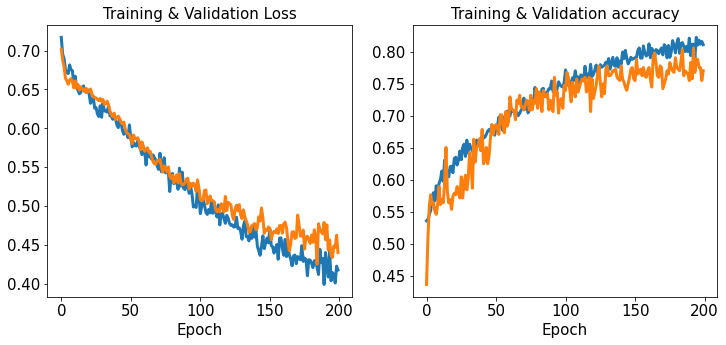

In [30]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [31]:
!pip install shap

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394119 sha256=08ab1541881f8cb69922dc402930faca73ac722e65c9cf88968236188228164b
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [32]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [33]:
shap_values  = explainer.shap_values(np.array(X_test_new))

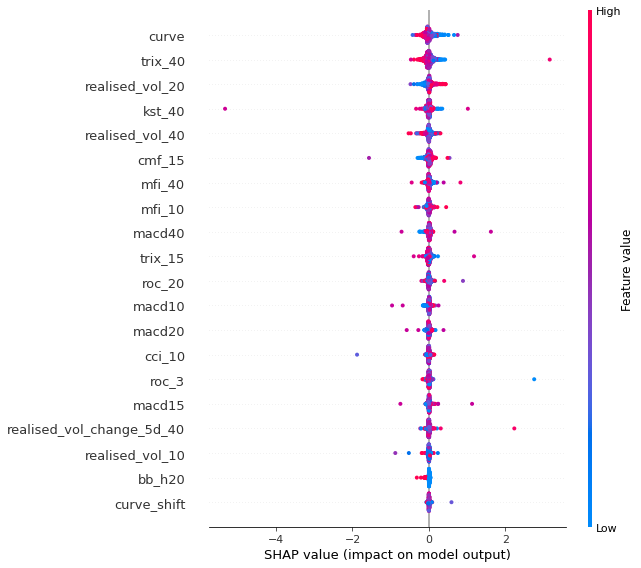

In [34]:
shap.summary_plot(shap_values[1], X_test_new)

In [35]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


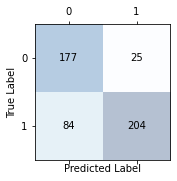

In [37]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [38]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.891
Recall: 0.708
F1: 0.789


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [41]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [42]:
search_space = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [10,20,25,30],
  }
]

In [44]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [45]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [47]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [48]:
model = grid.fit(normed_train_data, train_labels)

Fitting 10 folds for each of 4032 candidates, totalling 40320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 59.9min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 70.4min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 81.7min
[Parallel(n_jobs=-1)]: Done 11246 tasks      |

In [52]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/PG/xgb_log_reg.pickle', "wb"))

In [55]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.9385216769124435
Accuracy: 0.9020408163265307


Confusion Matrix


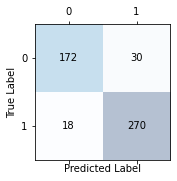

In [56]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [57]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 8, 'clf__n_estimators': 200, 'fs__k': 30, 'fs__score_func': <function f_classif at 0x7fee356c4c80>}


In [87]:
model = xgb.XGBClassifier(max_depth=8,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.0)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.246429	validation_0-logloss:0.660378	validation_1-error:0.373469	validation_1-logloss:0.67608
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.189796	validation_0-logloss:0.639474	validation_1-error:0.344898	validation_1-logloss:0.666561
[2]	validation_0-error:0.138776	validation_0-logloss:0.616075	validation_1-error:0.32449	validation_1-logloss:0.65515
[3]	validation_0-error:0.115816	validation_0-logloss:0.594298	validation_1-error:0.306122	validation_1-logloss:0.645418
[4]	validation_0-error:0.111224	validation_0-logloss:0.572622	validation_1-error:0.285714	validation_1-logloss:0.631896
[5]	validation_0-error:0.087755	validation_0-logloss:0.549838	validation_1-error:0.255102	validation_1-logloss:0.61679
[6]	validation_0-error:0.086735	validation_0-logloss:0.536342	validation_1-error:0.246939	validation_1-logloss:0.609789

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [88]:

# make predictions for test data
y_pred = model.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.20%


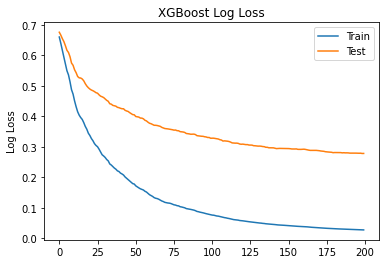

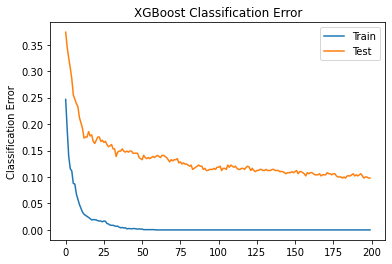

In [89]:
from matplotlib import pyplot

results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [90]:
shap_values = shap.TreeExplainer(model).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


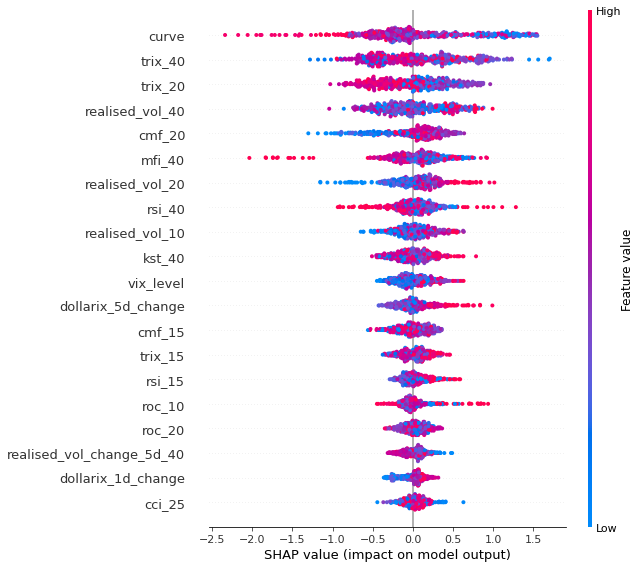

In [91]:
shap.summary_plot(shap_values, X_test_new)

In [92]:
predict = model.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


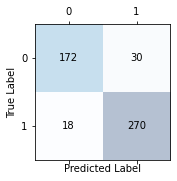

In [93]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()